## Step 1 - Launch PyMAPDL and Importing Libraries

In [13]:
mapdl.exit()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math

from ansys.mapdl.core import launch_mapdl
exec_loc = 'C:/Program Files/ANSYS Inc/ANSYS Student/v222/ANSYS/bin/winx64/ANSYS222.exe'
# exec_loc = 'D:/Program Files/ANSYS Inc/v222/ANSYS/bin/winx64/ANSYS222.exe'

# start mapdl
mapdl = launch_mapdl(exec_loc)
print(mapdl)

Product:             Ansys Mechanical Enterprise Academic Student
MAPDL Version:       22.2
ansys.mapdl Version: 0.63.1



## Step 2 - test subroutine on Fiber Elastic Energy

In [8]:
# these two classes does unit converts
class Material:
    """
    elastic modulus (kPa), 
    poisson ratio 
    work of adhesion (mJ/m^2)
    """
    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:
    """
    unit (um)
    """    
    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

# MAPDL codes for getting total elastic strain energy of one fiber under partial detachment
def get_Ue(mat, geo, c_r=None, force=None, disp=None, AESIZE=5, refine_lvl=3, detach_step=5):

    # reset mapdl
    try:
        mapdl.clear()
    except:
        print('warning: clear error')
        return None, None, False
    mapdl.prep7()   
    
    # Define element attributes
    # keyoption 3 = 1 (axis-symmetric formulation)
    mapdl.et(1, "PLANE182", kop3=1)
    
    # create cross-sectional area of fiber
    if geo.curve != []:
        line = geo.curve
        n = len(line)
        segment = geo.height/(n-1)     
        mapdl.flst(3, n, 3)
        for i in range(n):
            mapdl.k(i+2, line[i]+geo.diameter/2, i*segment)
            mapdl.fitem(3, i+2)
        mapdl.run('BSPLIN, ,P51X')
        mapdl.cm("curved_edge", "LINE")
        mapdl.k(1,0,0) # starting at origin
        mapdl.k(n+2,0,geo.height) # ending at the top
        mapdl.lstr(1,2)
        mapdl.lstr(n+1,n+2)
        mapdl.lstr(n+2,1)
#         mapdl.lplot('ALL',cpos="xy")
        try:
            mapdl.al('ALL')
        except:
            print('warning: curve generation error')
            mapdl.lplot('ALL',cpos="xy")
            return None, None, False
    else:
        mapdl.rectng(0, geo.diameter/2, 0, geo.height)
    
    mapdl.cm('fiber_cs', "AREA") # create 'area component' for the fiber

    mapdl.lsel("S", "LOC", "Y", geo.height)  # Select line on the top surface of fiber
    mapdl.cm("pulling_surface", "LINE")  # Create nodal component

    mapdl.lsel("S", "LOC", "X", 0)  # Select line
    mapdl.cm("symmetry_axis", "LINE")  # Create nodal component

    # Define material properties
    mapdl.mp("EX", 1, mat.E_modulus)  # Youngs modulus 
    mapdl.mp("PRXY", 1, mat.nu)  # Poissons ratio

    # global meshing
    mapdl.aesize('fiber_cs', AESIZE)
    mapdl.mshape(0, "2D")  # mesh the area with 2D Quad elements
    mapdl.mshkey(1)  # mapped mesh
    mapdl.cmsel("S", "fiber_cs")  
    try:
        mapdl.amesh("ALL")
    except:
        print('warning: mesh error in given shape')
        mapdl.lplot('ALL',cpos="xy")       
        return None, None, False

    if c_r==None: # argument not passed in
        if any(geo.curve):
            c_r = line[0]+geo.diameter/2 
#             print(f'c_r derived from curve as {c_r:.2f}') 
        else:
            c_r = geo.diameter/2
#             print(f'c_r defaults to 0.5*dia {c_r:.2f}') 
#     else:
#         print(f'c_r received as single value {c_r:.2f}')
        
    # local mesh refine
    mesh_refine_tip(AESIZE, detach_step, c_r, refine_lvl)
    
#     if geo.curve != []:
#         mesh_refine_edge(AESIZE, segment_length = segment)

    mapdl.slashsolu()  # Enter solution
    mapdl.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)

    mapdl.cmsel("ALL")
    mapdl.dl("symmetry_axis",'fiber_cs', "SYMM")  # apply axis symmetry BC to the entire cross-section, check necessity

    # create 'line component' for the fiber surface contacting glass
    mapdl.nsel("S", "LOC", "Y", 0)  # Select bottom line of fiber        
    mapdl.nsel("R", "LOC", "X", vmin = 0, vmax = c_r) # select the subset which are contacting
    mapdl.cm("contact_surface", "NODES")  # Create nodal component
    mapdl.d("contact_surface", "UY", 0)  # Fix the selected nodes in Y direction
    
    # print out mesh
#     mapdl.eplot(title='Element Plot', line_width=1, show_bounds=True, cpos="xy")
    
    # Apply uniform pressure load to the selected edge, when in 2D analysis where lines representing surfaces in 3D object
    if force and disp:
        print('model over constrained')
    elif force: 
        pressure = force/(0.25*math.pi*geo.diameter**2)
        mapdl.sfl("pulling_surface", "PRES", -pressure)
    elif disp:
        mapdl.dl("pulling_surface","fiber_cs","UY",disp)
    else:
        print('to apply either a Force of Displacement load')
        
    # introduce large deflection
    mapdl.nlgeom("ON")

    #Solve the model
    mapdl.allsel()
    
    mapdl.nsubst(10,1000,10)
    mapdl.outres('all','all')
    try:
        mapdl.solve()
    except:
        print(f'warning: other errors result in solving failure')
        return None, None, False
    if not mapdl.solution.converged:
        print(f'warning: solution not converged!')
        return None, None, False
    mapdl.finish()

    # Enter post-processor
    mapdl.post1()
    mapdl.set('LAST')  # Select the first load step and (first substep)

    # select all element
    # output the strain energy of all elements
    # strain_energy = mapdl.presol("SEND", "ENTO").to_array() # array of all strain energy, 
    try:
        mapdl.etable('Ue_d', 'SEND','ENTO')
        mapdl.etable('V', 'VOLU','ENTO')
        mapdl.smult('Ue','Ue_d','V')

        max_strain = np.max(mapdl.post_processing.nodal_total_eqv_strain())
        max_disp = np.max(mapdl.post_processing.nodal_displacement())
        result_sum = mapdl.ssum()
    except:
        print(f'warning: other errors result in empty result')
        return None, None, False
#     if max_strain > 1.5:
#         print('large deformation analysis requried')
    
#     result = mapdl.result
#     result.plot_nodal_displacement(0, cpos = 'xy')
    # manually export the ssum results
    index_start = result_sum.find('TABLE LABEL') # these two lines to remove header
    result_sum = result_sum[index_start:] 
    result_sum = result_sum.split('\n')[1:] # split into lines
    sum_dict = {}
    for item in result_sum:
        item = item.split()
        sum_dict[item[0]] = float(item[1]) # in each line, read the label and value as a dictionary item
    
#     print('tolist(result) =', mapdl.prnsol('S', 'PRIN',).to_list())
    
    mapdl.cmsel("S","contact_surface", "NODE")
    force_sum = mapdl.fsum()
    
    # manually export the fsum results
    index_start = force_sum.find('FX  =') # these 3 lines to remove header and footer
    index_end = force_sum.find('SUMMATION POINT')
    force_sum = force_sum[index_start:index_end] 
    force_sum = force_sum.split('\n')[0:6] # split into lines
    force_dict = {}
    for item in force_sum:
        item = item.split()
        force_dict[item[0]] = float(item[2]) # in each line, read the label and value as a dictionary item
            
    sum_dict['Fy'] = force_dict['FY']
    sum_dict['max_strain'] = max_strain
    sum_dict['max_dispacement'] = max_disp
    del sum_dict['UE_D']
    
    N_nodes = mapdl.mesh.nnum_all.size # number of nodes created by meshing

#     print(f'max_stn: {max_strain:5.1%}; \
#           disp: {max_disp:5.2f}um; \
#           F: {sum_dict["Fy"]:5.1f}uN; \
#           Ue: {sum_dict["UE"]:5.1f}; \
#           #Node: {N_nodes}'    
#          )

    return sum_dict, N_nodes, True

# in actual application, refinement level defaults to 3, density level increases per detach_step size
def mesh_refine_tip(AESIZE, detach_step, c_r, refine_lvl=0): 
    
    # determine refinement density level based on required detachment step.
    # target: local element size = 0.5 * detach_step size
    ratio = 0.5*detach_step/AESIZE
    if ratio >=1:
        print('warning: no refinement required as ratio >=1')
        return
    elif ratio >=0.064:
        density_lvl = 1
        refine_lvl = math.ceil(math.log(ratio, 0.5))
    elif ratio >=0.013:
        density_lvl = 2
        refine_lvl = math.ceil(math.log(ratio, 0.33))
    else:
        density_lvl = 2
        refine_lvl = 5
        print('warning: excessive refinement, stopped at 0.043=230x')
#     print(f'den = {density_lvl}, ref = {refine_lvl}')

    for lvl in range(refine_lvl):
        half_region = AESIZE/(2*(2**(lvl)))
#         print('half region = ', half_region)
        mapdl.nsel("S", "LOC", "Y", 0)
#         print(mapdl.nlist('ALL'))
        mapdl.nsel("R", "LOC", "X", c_r-half_region, c_r+half_region)
        
        mapdl.cm(f"detach_tip_{lvl}", 'NODES')
        mapdl.nrefine(nn1=f"detach_tip_{lvl}",level=density_lvl, depth=2, post='CLEAN', retain='OFF')
        mapdl.run('nsel, all')
#         print(f'level = {lvl}, half_region = {half_region:.2f}, region = {15-half_region:.2f}, {15+half_region:.2f}')
    return

# in actual application, refinement level defaults to 3, density level increases per curve segments number
def mesh_refine_edge(AESIZE, segment_length = 5):
    
    # determine refinement density level based on no. of curve segments.
    # target: local element size = 0.5 * curve segment length    
    ratio = 0.5*segment_length/AESIZE
    if ratio >=1:
        print('warning: no refinement required as ratio >=1')
        return
    elif ratio >=0.064:
        density_lvl = 1
        refine_lvl = math.ceil(math.log(ratio, 0.5))
    elif ratio >=0.013:
        density_lvl = 2
        refine_lvl = math.ceil(math.log(ratio, 0.33))
    else:
        density_lvl = 2
        refine_lvl = 5
        print('warning: excessive refinement, stopped at 0.043=230x')
#     print(f'den = {density_lvl}, ref = {refine_lvl}')
    
    # density_lvl = math.ceil((6/detach_step)**(1/3) - 1)
    
    for lvl in range(refine_lvl):
        mapdl.cmsel("s", "curved_edge", 'LINE')
        mapdl.lrefine(nl1="curved_edge",level=density_lvl, depth=2, post='CLEAN', retain='ON')
        mapdl.run('nsel, all')
    return    

In [9]:
# mat = Material()
# geo = Geometry()
# get_Ue(mat, geo, c_r=15, force=None, disp=15, AESIZE=5, refine_lvl=3, detach_step=5)

# mapdl.post1()
# mapdl.allsel()
# mapdl.set('last')
# mapdl.upcoord(1)
# mapdl.eplot(cpos='xy', background='black', color='blue',edge_color='white', notebook = False)
# mapdl.upcoord(-1)

## Step 3 - Dynamic fiber tensile force routine

In [10]:
class Fiber:    # fiber object that calculates its own max adhesion and 

    def __init__(self, mat, geo, detach_step=5, disp_step=1):
        self.mat = mat
        self.geo = geo
        if geo.curve != []:                                 # radius of surface contact with rigid half surface
            self.c_r = geo.curve[0] + geo.diameter/2                        
        else:
            self.c_r = geo.diameter/2
        self.detach_step = detach_step
        self.disp_step = disp_step
        self.w_ad = mat.w_ad                                # work of adhesion between fiber and glass
        self.Ue = 0                                         # total elastic energy at current tensile load and contact area
        self.F_ad = 0                                       # current max tested adhesion strengh
        self.complete_detach = False                        # boolean to indicate complete detachment
        self.failed_line = None
        
    def Uelastic(self, displacement, c_r):       # update the total elastic energy in the fiber based on current tensile load
        
        sum_dict, _, converge = get_Ue(self.mat, self.geo, c_r, disp=displacement, detach_step = self.detach_step)        # update the Ue of fiber
        if converge == False:
            self.complete_detach = True
            self.F_ad = 0
            self.failed_line = self.geo.curve
            return 0, 0, False
        Ue = sum_dict['UE']
        force = sum_dict['Fy']
        return Ue, force, converge

    def find_F_ad(self):        # iteratively update F_ad via checking detachment until complete detachment
        displacement = 0        # potentially can be optimizied to save computation
        while self.complete_detach == False:
            displacement += self.disp_step
            self.check_detach(displacement, self.c_r)     
        return self.F_ad

    def check_detach(self, displacement, c_r):   # helper function to check for detachment using recursion
        if c_r-self.detach_step <= 0:    # terminal condition when fiber completely detached
#             print(f"detachment completed at {displacement}um\n")
            self.complete_detach = True
            return
        
        Ue_0, force_0, converge = self.Uelastic(displacement, c_r)                  # readout elastic energy of fiber at current contact_radius
        if not converge:
            return
        Ue_1, force_1, converge = self.Uelastic(displacement, c_r-self.detach_step)      # readout elastic energy of fiber at reduced contact_radius
        if not converge:
            return
        dUe = Ue_0 - Ue_1                                                 # calc elastic energy release rate by one-step-lookahead
        dUw = c_r*self.detach_step*self.w_ad            # calc surface energy gain rate by one-step-lookahead
        self.F_ad = max(self.F_ad, force_0)
        
#         print(f'at contact radius {c_r:.1f}um -> {c_r-self.detach_step:.1f}um, dUe = {dUe:.2f}pJ, dUw = {dUw:.2f}pJ')

        if dUe <= dUw:      # if elastic release < surface gain, detachment stops at the current contact radius
#             print(f"insufficient elastic energy to drive detachment at displacement={displacement}um\t radius={self.c_r}um\n")
            return
        
        else:
#             print(f"detachment progresses under displacement {displacement}um\n")
            self.c_r -= self.detach_step*100 # this is to skip the steps which are most likely to have detachment progressions
            self.check_detach(displacement, self.c_r)

## Step 5 - Fiber with Profile created by Fourier Series

In [11]:
# generating Fourier Coefficients and line
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from math import* #import all function from math

def Coefficient_Gen(pop_size, mode = 20, center_tolerance=1, max_amplitude=8):
    n = mode   
    tol = center_tolerance
    
    Ans = np.empty(shape = (0,20))
    Bns = np.empty(shape = (0,20))
#     print(Ans.shape, Ans[:,:6])
    
    while Ans[:,0].size < pop_size:
        An = np.expand_dims(np.array([random.uniform(-1, 1) for _ in range(n)]), axis = 0)
        Bn = np.expand_dims(np.array([random.uniform(-1, 1) for _ in range(n)]), axis = 0)
        line = to_Fourier(An, Bn)
        line_max = np.absolute(line).max()
        line_avg = np.average(line) 
        if line_avg<-tol or line_avg>tol or line_max>max_amplitude:
            continue
        Ans = np.vstack((Ans, An))
        Bns = np.vstack((Bns, Bn))
        DNAs = np.hstack((Ans, Bns))
#         print(Ans.shape)
    return DNAs
    
# array compatible
def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)

#     plt.plot(x,total,'g')
#     plt.title("fourier series generated")
#     plt.show()

    return total


## Step 6 - GA to optimize the Fiber Curved Surface

F_ad_0 = 43.70
F_ad_1 = 47.51
F_ad_2 = 79.40
F_ad_3 = 51.96
F_ad_4 = 41.22
F_ad_5 = 109.03
F_ad_6 = 41.90
F_ad_7 = 56.30
F_ad_8 = 41.23
F_ad_9 = 25.30
F_ad_10 = 25.52
F_ad_11 = 70.14
F_ad_12 = 42.77
F_ad_13 = 64.44
F_ad_14 = 41.04
F_ad_15 = 27.38
F_ad_16 = 35.39
F_ad_17 = 45.31
F_ad_18 = 33.75
F_ad_19 = 49.22
F_ad_20 = 55.65
F_ad_21 = 40.92
F_ad_22 = 35.98
F_ad_23 = 50.98
F_ad_24 = 57.45
F_ad_25 = 77.78
F_ad_26 = 116.53
F_ad_27 = 39.79
F_ad_28 = 35.44
F_ad_29 = 27.75
F_ad_30 = 25.96
F_ad_31 = 27.77
F_ad_32 = 32.74
F_ad_33 = 34.08
F_ad_34 = 52.38
F_ad_35 = 62.16
F_ad_36 = 57.59
F_ad_37 = 27.09
F_ad_38 = 33.66
F_ad_39 = 59.91
F_ad_40 = 45.00
F_ad_41 = 51.36
F_ad_42 = 45.02
F_ad_43 = 55.33
F_ad_44 = 26.68
F_ad_45 = 78.68
F_ad_46 = 57.17
F_ad_47 = 89.55
F_ad_48 = 42.24
F_ad_49 = 208.85
F_ad_50 = 112.72
F_ad_51 = 17.81
F_ad_52 = 48.89
F_ad_53 = 42.82
F_ad_54 = 0.00
F_ad_55 = 26.32
F_ad_56 = 82.48
F_ad_57 = 24.71
F_ad_58 = 55.74
F_ad_59 = 25.51
F_ad_60 = 108.78
F_ad_61 = 34.54
F_ad_62 = 43.5

F_ad_85 = 96.84
F_ad_86 = 55.23
F_ad_87 = 84.59
F_ad_88 = 49.14
F_ad_89 = 74.71
F_ad_90 = 157.21
F_ad_91 = 26.91
F_ad_92 = 47.63
F_ad_93 = 56.51
F_ad_94 = 76.49
F_ad_95 = 60.69
F_ad_96 = 109.29
F_ad_97 = 0.00
F_ad_98 = 208.38
F_ad_99 = 57.78
gen3: avg=81.1, max=250.2, best =[ 7.20502725  5.90744447 -3.16244202  1.9260289   0.94999643  1.1683077
  0.39943475 -2.51351257  0.57378687 -1.47885009  0.14282548  0.60439581
  0.79647947 -6.10523715  1.91836591 -1.22898201  0.1181946  -1.00881237
  5.10873337 -2.11768411]
F_ad_0 = 284.44
F_ad_1 = 80.44
F_ad_2 = 76.93
F_ad_3 = 73.01
F_ad_4 = 55.27
F_ad_5 = 123.62
F_ad_6 = 42.90
F_ad_7 = 33.39
F_ad_8 = 0.00
F_ad_9 = 179.03
F_ad_10 = 70.80
F_ad_11 = 0.00
F_ad_12 = 71.01
F_ad_13 = 55.23
F_ad_14 = 80.82
F_ad_15 = 73.09
F_ad_16 = 106.80
F_ad_17 = 0.00
F_ad_18 = 71.23
F_ad_19 = 49.70
F_ad_20 = 137.58
F_ad_21 = 90.88
F_ad_22 = 97.14
F_ad_23 = 170.91
F_ad_24 = 75.16
F_ad_25 = 179.03
F_ad_26 = 0.00
F_ad_27 = 157.21
F_ad_28 = 62.97
F_ad_29 = 0.00
F_ad_30 

F_ad_49 = 105.85
F_ad_50 = 0.00
F_ad_51 = 114.18
F_ad_52 = 125.13
F_ad_53 = 131.27
F_ad_54 = 68.58
F_ad_55 = 70.96
F_ad_56 = 181.30
F_ad_57 = 70.51
F_ad_58 = 0.00
F_ad_59 = 82.67
F_ad_60 = 99.49
F_ad_61 = 236.15
F_ad_62 = 66.46
F_ad_63 = 0.00
F_ad_64 = 77.05
F_ad_65 = 131.27
F_ad_66 = 79.99
F_ad_67 = 184.16
F_ad_68 = 77.60
F_ad_69 = 0.00
F_ad_70 = 58.87
F_ad_71 = 83.06
F_ad_72 = 128.37
F_ad_73 = 63.37
F_ad_74 = 75.72
F_ad_75 = 157.47
F_ad_76 = 54.80
F_ad_77 = 72.50
F_ad_78 = 105.30
F_ad_79 = 102.69
F_ad_80 = 73.11
F_ad_81 = 98.29
F_ad_82 = 0.00
F_ad_83 = 88.69
F_ad_84 = 131.27
F_ad_85 = 214.72
F_ad_86 = 111.50
F_ad_87 = 212.92
F_ad_88 = 74.23
F_ad_89 = 81.29
F_ad_90 = 172.00
F_ad_91 = 0.00
F_ad_92 = 104.30
F_ad_93 = 228.90
F_ad_94 = 248.68
F_ad_95 = 76.72
F_ad_96 = 124.85
F_ad_97 = 74.22
F_ad_98 = 172.52
F_ad_99 = 122.40
gen7: avg=110.6, max=248.7, best =[ 5.17417288 -0.90602584  0.93676697  0.90961304  3.65410699  0.06711863
 -0.53185653 -0.31581054  0.14584167 -1.21563944 -1.09253961

F_ad_0 = 219.08
F_ad_1 = 0.00
F_ad_2 = 92.89
F_ad_3 = 78.88
F_ad_4 = 86.45
F_ad_5 = 195.61
F_ad_6 = 135.71
F_ad_7 = 85.14
F_ad_8 = 125.46
F_ad_9 = 70.65
F_ad_10 = 168.49
F_ad_11 = 85.06
F_ad_12 = 243.74
F_ad_13 = 103.75
F_ad_14 = 78.99
F_ad_15 = 98.80
F_ad_16 = 96.87
F_ad_17 = 111.37
F_ad_18 = 0.00
F_ad_19 = 105.92
F_ad_20 = 101.71
F_ad_21 = 187.41
F_ad_22 = 140.94
F_ad_23 = 152.34
F_ad_24 = 167.87
F_ad_25 = 191.68
F_ad_26 = 267.25
F_ad_27 = 152.05
F_ad_28 = 0.00
F_ad_29 = 33.36
F_ad_30 = 0.00
F_ad_31 = 213.40
F_ad_32 = 0.00
F_ad_33 = 204.89
F_ad_34 = 123.04
F_ad_35 = 98.12
F_ad_36 = 136.26
F_ad_37 = 0.00
F_ad_38 = 159.23
F_ad_39 = 189.78
F_ad_40 = 189.78
F_ad_41 = 93.54
F_ad_42 = 98.29
F_ad_43 = 57.58
F_ad_44 = 102.45
F_ad_45 = 101.97
F_ad_46 = 103.72
F_ad_47 = 0.00
F_ad_48 = 68.82
F_ad_49 = 104.27
F_ad_50 = 121.60
F_ad_51 = 105.49
F_ad_52 = 153.99
F_ad_53 = 84.08
F_ad_54 = 84.78
F_ad_55 = 85.07
F_ad_56 = 115.72
F_ad_57 = 104.43
F_ad_58 = 71.05
F_ad_59 = 42.53
F_ad_60 = 70.12
F_ad_61 

F_ad_73 = 169.82
F_ad_74 = 85.85
F_ad_75 = 143.34
F_ad_76 = 83.24
F_ad_77 = 79.10
F_ad_78 = 133.57
F_ad_79 = 197.64
F_ad_80 = 84.61
F_ad_81 = 92.63
F_ad_82 = 211.49
F_ad_83 = 114.18
F_ad_84 = 86.87
F_ad_85 = 181.73
F_ad_86 = 83.72
F_ad_87 = 94.08
F_ad_88 = 161.15
F_ad_89 = 145.18
F_ad_90 = 136.66
F_ad_91 = 64.10
F_ad_92 = 153.63
F_ad_93 = 0.00
F_ad_94 = 93.78
F_ad_95 = 65.29
F_ad_96 = 95.79
F_ad_97 = 104.18
F_ad_98 = 80.88
F_ad_99 = 113.19
gen14: avg=119.9, max=290.1, best =[ 6.96418717  0.90595916 -1.41201062 -0.96406491 -1.4138102  -0.25739361
 -1.64938833 -1.14264064 -1.24632388 -3.40203409  1.76816944 -3.18876199
 -2.23022759 -0.53242222  2.6569812   1.44565043 -2.80135925 -1.68652594
 -0.350439    1.3788485 ]
F_ad_0 = 202.36
F_ad_1 = 69.94
F_ad_2 = 77.91
F_ad_3 = 91.24
F_ad_4 = 0.00
F_ad_5 = 207.04
F_ad_6 = 144.90
F_ad_7 = 244.00
F_ad_8 = 119.21
F_ad_9 = 62.52
F_ad_10 = 108.24
F_ad_11 = 106.49
F_ad_12 = 127.93
F_ad_13 = 163.90
F_ad_14 = 0.00
F_ad_15 = 133.57
F_ad_16 = 78.43
F_ad_1

F_ad_28 = 225.46
F_ad_29 = 0.00
F_ad_30 = 63.55
F_ad_31 = 88.33
F_ad_32 = 77.30
F_ad_33 = 152.71
F_ad_34 = 119.40
F_ad_35 = 118.36
F_ad_36 = 209.24
F_ad_37 = 111.80
F_ad_38 = 109.81
F_ad_39 = 156.68
F_ad_40 = 241.72
F_ad_41 = 166.53
F_ad_42 = 229.35
F_ad_43 = 147.26
F_ad_44 = 77.24
F_ad_45 = 130.18
F_ad_46 = 0.00
F_ad_47 = 206.07
F_ad_48 = 194.57
F_ad_49 = 140.76
F_ad_50 = 0.00
F_ad_51 = 207.60
F_ad_52 = 189.70
F_ad_53 = 189.85
F_ad_54 = 146.66
F_ad_55 = 175.37
F_ad_56 = 0.00
F_ad_57 = 178.90
F_ad_58 = 127.66
F_ad_59 = 91.42
F_ad_60 = 194.56
F_ad_61 = 144.00
F_ad_62 = 0.00
F_ad_63 = 136.11
F_ad_64 = 0.00
F_ad_65 = 178.90
F_ad_66 = 161.30
F_ad_67 = 86.10
F_ad_68 = 108.23
F_ad_69 = 84.35
F_ad_70 = 109.58
F_ad_71 = 135.65
F_ad_72 = 179.55
F_ad_73 = 115.48
F_ad_74 = 193.42
F_ad_75 = 0.00
F_ad_76 = 79.88
F_ad_77 = 71.97
F_ad_78 = 151.59
F_ad_79 = 118.03
F_ad_80 = 95.77
F_ad_81 = 131.79
F_ad_82 = 224.89
F_ad_83 = 83.84
F_ad_84 = 196.95
F_ad_85 = 102.68
F_ad_86 = 310.36
F_ad_87 = 226.10
F_ad_

F_ad_87 = 142.85
F_ad_88 = 134.91
F_ad_89 = 133.65
F_ad_90 = 132.98
F_ad_91 = 0.00
F_ad_92 = 81.32
F_ad_93 = 193.42
F_ad_94 = 129.99
F_ad_95 = 71.93
F_ad_96 = 102.13
F_ad_97 = 98.87
F_ad_98 = 0.00
F_ad_99 = 0.00
gen21: avg=121.8, max=269.0, best =[ 6.34179435  1.11196061 -2.65079234  0.24187247  1.86406662 -1.66878045
  0.06470606  0.09781372  3.32839081 -3.93279117  1.03318003 -0.04177456
 -2.42033168 -0.53453207  1.58721675 -1.82441377 -3.12345015 -4.80815169
  0.87967182 -0.63405435]
F_ad_0 = 109.07
F_ad_1 = 165.60
F_ad_2 = 116.65
F_ad_3 = 0.00
F_ad_4 = 129.99
F_ad_5 = 69.85
F_ad_6 = 216.63
F_ad_7 = 0.00
F_ad_8 = 0.00
F_ad_9 = 111.57
F_ad_10 = 0.00
F_ad_11 = 97.63
F_ad_12 = 148.08
F_ad_13 = 216.98
F_ad_14 = 204.35
F_ad_15 = 209.99
F_ad_16 = 89.76
F_ad_17 = 224.25
F_ad_18 = 148.78
F_ad_19 = 0.00
F_ad_20 = 122.63
F_ad_21 = 119.53
F_ad_22 = 237.29
F_ad_23 = 121.00
F_ad_24 = 138.87
F_ad_25 = 109.82
F_ad_26 = 81.35
F_ad_27 = 215.72
F_ad_28 = 139.71
F_ad_29 = 203.22
F_ad_30 = 134.49
F_ad_

F_ad_26 = 134.40
F_ad_27 = 115.42
F_ad_28 = 111.11
F_ad_29 = 261.03
F_ad_30 = 252.01
F_ad_31 = 0.00
F_ad_32 = 76.96
F_ad_33 = 90.33
F_ad_34 = 186.15
F_ad_35 = 173.09
F_ad_36 = 69.84
F_ad_37 = 234.37
F_ad_38 = 121.74
F_ad_39 = 0.00
F_ad_40 = 118.88
F_ad_41 = 234.98
F_ad_42 = 0.00
F_ad_43 = 232.93
F_ad_44 = 205.97
F_ad_45 = 123.70
F_ad_46 = 84.73
F_ad_47 = 281.67
F_ad_48 = 192.27
F_ad_49 = 195.79
F_ad_50 = 0.00
F_ad_51 = 215.27
F_ad_52 = 206.30
F_ad_53 = 123.31
F_ad_54 = 98.67
F_ad_55 = 132.53
F_ad_56 = 123.47
F_ad_57 = 90.66
F_ad_58 = 102.87
F_ad_59 = 104.33
F_ad_60 = 0.00
F_ad_61 = 0.00
F_ad_62 = 225.52
F_ad_63 = 152.79
F_ad_64 = 226.85
F_ad_65 = 72.41
F_ad_66 = 165.78
F_ad_67 = 267.84
F_ad_68 = 277.40
F_ad_69 = 0.00
F_ad_70 = 102.20
F_ad_71 = 85.24
F_ad_72 = 106.26
F_ad_73 = 0.00
F_ad_74 = 183.68
F_ad_75 = 121.88
F_ad_76 = 233.20
F_ad_77 = 170.88
F_ad_78 = 0.00
F_ad_79 = 0.00
F_ad_80 = 147.99
F_ad_81 = 91.83
F_ad_82 = 115.00
F_ad_83 = 99.64
F_ad_84 = 111.28
F_ad_85 = 206.30
F_ad_86 = 

F_ad_75 = 248.15
F_ad_76 = 118.96
F_ad_77 = 0.00
F_ad_78 = 209.36
F_ad_79 = 123.14
F_ad_80 = 157.94
F_ad_81 = 109.72
F_ad_82 = 232.85
F_ad_83 = 212.62
F_ad_84 = 0.00
F_ad_85 = 223.78
F_ad_86 = 133.93
F_ad_87 = 203.71
F_ad_88 = 289.59
F_ad_89 = 0.00
F_ad_90 = 186.65
F_ad_91 = 130.29
F_ad_92 = 253.21
F_ad_93 = 234.96
F_ad_94 = 263.75
F_ad_95 = 167.66
F_ad_96 = 284.99
F_ad_97 = 166.68
F_ad_98 = 103.20
F_ad_99 = 247.66
gen28: avg=170.5, max=289.6, best =[ 7.87394039  1.20622943 -1.53452768 -1.35225438  3.08736645 -1.86237378
 -2.39160937 -0.52183535  0.18494716 -3.47126064  0.17519131  2.25038402
 -4.55935885  1.26081625  1.59129848  2.99010629 -2.4264841   2.38203502
  0.95760545  3.82078396]
F_ad_0 = 0.00
F_ad_1 = 92.98
F_ad_2 = 195.46
F_ad_3 = 132.78
F_ad_4 = 172.95
F_ad_5 = 113.03
F_ad_6 = 200.56
F_ad_7 = 110.46
F_ad_8 = 79.12
F_ad_9 = 0.00
F_ad_10 = 254.75
F_ad_11 = 212.59
F_ad_12 = 181.93
F_ad_13 = 84.51
F_ad_14 = 210.29
F_ad_15 = 0.00
F_ad_16 = 0.00
F_ad_17 = 211.52
F_ad_18 = 284.99

F_ad_27 = 155.64
F_ad_28 = 132.79
F_ad_29 = 0.00
F_ad_30 = 164.17
F_ad_31 = 111.46
F_ad_32 = 221.77
F_ad_33 = 84.29
F_ad_34 = 306.18
F_ad_35 = 224.06
F_ad_36 = 182.58
F_ad_37 = 214.21
F_ad_38 = 177.44
F_ad_39 = 243.68
F_ad_40 = 257.82
F_ad_41 = 260.24
F_ad_42 = 149.85
F_ad_43 = 217.59
F_ad_44 = 0.00
F_ad_45 = 184.24
F_ad_46 = 237.33
F_ad_47 = 218.98
F_ad_48 = 307.14
F_ad_49 = 185.85
F_ad_50 = 0.00
F_ad_51 = 132.87
F_ad_52 = 158.42
F_ad_53 = 192.87
F_ad_54 = 118.65
F_ad_55 = 53.72
F_ad_56 = 279.71
F_ad_57 = 153.37
F_ad_58 = 247.38
F_ad_59 = 110.17
F_ad_60 = 214.68
F_ad_61 = 0.00
F_ad_62 = 137.20
F_ad_63 = 113.94
F_ad_64 = 210.89
F_ad_65 = 149.71
F_ad_66 = 85.91
F_ad_67 = 199.33
F_ad_68 = 133.60
F_ad_69 = 202.97
F_ad_70 = 112.06
F_ad_71 = 191.36
F_ad_72 = 212.13
F_ad_73 = 151.06
F_ad_74 = 214.82
F_ad_75 = 201.37
F_ad_76 = 90.26
F_ad_77 = 254.75
F_ad_78 = 109.20
F_ad_79 = 0.00
F_ad_80 = 129.69
F_ad_81 = 213.20
F_ad_82 = 116.59
F_ad_83 = 256.70
F_ad_84 = 151.33
F_ad_85 = 198.32
F_ad_86 = 1

F_ad_0 = 70.00
F_ad_1 = 145.77
F_ad_2 = 270.01
F_ad_3 = 164.65
F_ad_4 = 148.90
F_ad_5 = 186.81
F_ad_6 = 232.38
F_ad_7 = 143.37
F_ad_8 = 259.99
F_ad_9 = 164.65
F_ad_10 = 200.02
F_ad_11 = 187.44
F_ad_12 = 229.73
F_ad_13 = 0.00
F_ad_14 = 114.21
F_ad_15 = 197.99
F_ad_16 = 232.56
F_ad_17 = 174.95
F_ad_18 = 86.17
F_ad_19 = 228.12
F_ad_20 = 134.11
F_ad_21 = 166.85
F_ad_22 = 112.60
F_ad_23 = 93.15
F_ad_24 = 315.23
F_ad_25 = 110.29
F_ad_26 = 143.82
F_ad_27 = 227.60
F_ad_28 = 209.12
F_ad_29 = 200.10
F_ad_30 = 119.40
F_ad_31 = 188.44
F_ad_32 = 224.61
F_ad_33 = 0.00
F_ad_34 = 224.76
F_ad_35 = 252.84
F_ad_36 = 237.73
F_ad_37 = 119.58
F_ad_38 = 188.48
F_ad_39 = 0.00
F_ad_40 = 301.38
F_ad_41 = 111.38
F_ad_42 = 223.51
F_ad_43 = 249.60
F_ad_44 = 132.97
F_ad_45 = 272.56
F_ad_46 = 169.79
F_ad_47 = 144.86
F_ad_48 = 164.09
F_ad_49 = 224.74
F_ad_50 = 266.96
F_ad_51 = 0.00
F_ad_52 = 134.67
F_ad_53 = 261.60
F_ad_54 = 200.53
F_ad_55 = 151.51
F_ad_56 = 259.00
F_ad_57 = 146.95
F_ad_58 = 166.89
F_ad_59 = 224.92
F

F_ad_60 = 213.03
F_ad_61 = 228.79
F_ad_62 = 0.00
F_ad_63 = 217.55
F_ad_64 = 168.78
F_ad_65 = 207.62
F_ad_66 = 290.95
F_ad_67 = 233.23
F_ad_68 = 276.73
F_ad_69 = 265.16
F_ad_70 = 222.34
F_ad_71 = 99.53
F_ad_72 = 230.41
F_ad_73 = 164.38
F_ad_74 = 207.53
F_ad_75 = 185.25
F_ad_76 = 186.33
F_ad_77 = 0.00
F_ad_78 = 197.90
F_ad_79 = 239.70
F_ad_80 = 238.45
F_ad_81 = 109.16
F_ad_82 = 246.66
F_ad_83 = 224.78
F_ad_84 = 236.76
F_ad_85 = 168.78
F_ad_86 = 151.94
F_ad_87 = 235.42
F_ad_88 = 218.32
F_ad_89 = 205.90
F_ad_90 = 266.68
F_ad_91 = 211.49
F_ad_92 = 185.13
F_ad_93 = 275.49
F_ad_94 = 169.42
F_ad_95 = 300.50
F_ad_96 = 227.22
F_ad_97 = 247.37
F_ad_98 = 145.67
F_ad_99 = 191.13
gen39: avg=185.7, max=300.5, best =[ 7.52831844  1.9422184  -1.11763042 -1.10035286  0.27911467 -2.53468267
  0.36560589 -0.11482595 -1.4450674  -1.76963336  0.51166866  1.28867084
 -0.13203    -1.67325515  2.21422082  0.24515644  3.34034471 -1.85947033
  2.23436263  1.4582667 ]
F_ad_0 = 234.70
F_ad_1 = 301.82
F_ad_2 = 0.00

F_ad_0 = 150.52
F_ad_1 = 217.50
F_ad_2 = 243.69
F_ad_3 = 164.53
F_ad_4 = 246.99
F_ad_5 = 199.09
F_ad_6 = 161.05
F_ad_7 = 91.97
F_ad_8 = 202.77
F_ad_9 = 0.00
F_ad_10 = 188.74
F_ad_11 = 248.35
F_ad_12 = 120.52
F_ad_13 = 261.65
F_ad_14 = 159.02
F_ad_15 = 268.41
F_ad_16 = 246.44
F_ad_17 = 203.02
F_ad_18 = 255.32
F_ad_19 = 277.40
F_ad_20 = 280.85
F_ad_21 = 237.59
F_ad_22 = 180.50
F_ad_23 = 293.75
F_ad_24 = 189.22
F_ad_25 = 227.87
F_ad_26 = 225.83
F_ad_27 = 147.83
F_ad_28 = 150.65
F_ad_29 = 126.07
F_ad_30 = 176.37
F_ad_31 = 250.94
F_ad_32 = 113.05
F_ad_33 = 0.00
F_ad_34 = 221.02
F_ad_35 = 204.08
F_ad_36 = 336.76
F_ad_37 = 224.09
F_ad_38 = 161.52
F_ad_39 = 246.16
F_ad_40 = 197.53
F_ad_41 = 223.47
F_ad_42 = 235.10
F_ad_43 = 209.91
F_ad_44 = 231.50
F_ad_45 = 259.66
F_ad_46 = 171.25
F_ad_47 = 191.51
F_ad_48 = 284.37
F_ad_49 = 0.00
F_ad_50 = 280.96
F_ad_51 = 228.40
F_ad_52 = 177.16
F_ad_53 = 225.60
F_ad_54 = 160.58
F_ad_55 = 243.66
F_ad_56 = 313.97
F_ad_57 = 179.10
F_ad_58 = 257.12
F_ad_59 = 254.

F_ad_66 = 212.99
F_ad_67 = 0.00
F_ad_68 = 188.96
F_ad_69 = 209.23
F_ad_70 = 205.94
F_ad_71 = 167.00
F_ad_72 = 147.31
F_ad_73 = 0.00
F_ad_74 = 208.27
F_ad_75 = 246.65
F_ad_76 = 240.65
F_ad_77 = 259.12
F_ad_78 = 154.70
F_ad_79 = 286.33
F_ad_80 = 152.91
F_ad_81 = 203.34
F_ad_82 = 215.22
F_ad_83 = 125.60
F_ad_84 = 252.52
F_ad_85 = 206.13
F_ad_86 = 215.22
F_ad_87 = 244.01
F_ad_88 = 0.00
F_ad_89 = 0.00
F_ad_90 = 190.37
F_ad_91 = 154.90
F_ad_92 = 0.00
F_ad_93 = 232.52
F_ad_94 = 247.74
F_ad_95 = 216.12
F_ad_96 = 211.83
F_ad_97 = 191.15
F_ad_98 = 219.65
F_ad_99 = 249.95
gen46: avg=185.3, max=300.9, best =[ 7.85757976  3.06062313 -2.3012094   1.31092243 -1.80207533 -0.17218752
 -3.57583488  0.67624247 -2.18289328 -0.39612124  0.21602372  0.71842046
 -0.96323952 -1.31649394  1.53500921  0.97203309  1.10805681 -1.66037415
  3.06695214  3.5095661 ]
F_ad_0 = 246.31
F_ad_1 = 136.97
F_ad_2 = 206.95
F_ad_3 = 243.25
F_ad_4 = 223.20
F_ad_5 = 260.66
F_ad_6 = 270.00
F_ad_7 = 125.60
F_ad_8 = 134.06
F_ad_9 =

F_ad_32 = 260.03
F_ad_33 = 252.33
F_ad_34 = 151.44
F_ad_35 = 188.15
F_ad_36 = 265.61
F_ad_37 = 0.00
F_ad_38 = 112.09
F_ad_39 = 252.13
F_ad_40 = 269.78
F_ad_41 = 219.64
F_ad_42 = 191.22
F_ad_43 = 0.00
F_ad_44 = 206.86
F_ad_45 = 280.44
F_ad_46 = 178.23
F_ad_47 = 252.08
F_ad_48 = 0.00
F_ad_49 = 0.00
F_ad_50 = 294.97
F_ad_51 = 198.02
F_ad_52 = 172.64
F_ad_53 = 170.45
F_ad_54 = 264.95
F_ad_55 = 213.58
F_ad_56 = 243.85
F_ad_57 = 237.10
F_ad_58 = 176.62
F_ad_59 = 271.85
F_ad_60 = 246.08
F_ad_61 = 0.00
F_ad_62 = 222.81
F_ad_63 = 170.70
F_ad_64 = 227.53
F_ad_65 = 294.97
F_ad_66 = 0.00
F_ad_67 = 0.00
F_ad_68 = 253.33
F_ad_69 = 218.63
F_ad_70 = 214.22
F_ad_71 = 207.15
F_ad_72 = 0.00
F_ad_73 = 187.44
F_ad_74 = 238.36
F_ad_75 = 210.92
F_ad_76 = 294.97
F_ad_77 = 164.14
F_ad_78 = 208.83
F_ad_79 = 0.00
F_ad_80 = 328.21
F_ad_81 = 237.10
F_ad_82 = 266.38
F_ad_83 = 253.39
F_ad_84 = 228.23
F_ad_85 = 176.06
F_ad_86 = 187.68
F_ad_87 = 137.32
F_ad_88 = 236.48
F_ad_89 = 0.00
F_ad_90 = 122.53
F_ad_91 = 264.95


F_ad_78 = 229.44
F_ad_79 = 231.14
F_ad_80 = 208.98
F_ad_81 = 241.58
F_ad_82 = 216.51
F_ad_83 = 212.52
F_ad_84 = 216.43
F_ad_85 = 209.86
F_ad_86 = 132.98
F_ad_87 = 243.35
F_ad_88 = 230.05
F_ad_89 = 164.88
F_ad_90 = 172.17
F_ad_91 = 162.77
F_ad_92 = 282.38
F_ad_93 = 144.35
F_ad_94 = 100.11
F_ad_95 = 228.58
F_ad_96 = 210.10
F_ad_97 = 241.56
F_ad_98 = 208.01
F_ad_99 = 242.02
gen53: avg=193.2, max=299.9, best =[ 7.73616202  1.29099202  0.97165061 -1.97187413 -0.12042384 -3.71412746
  0.36527182 -2.6552443  -1.82869886 -3.72290636  1.43289566  0.81808784
 -0.71671492  0.32189456  1.85572578  3.53386627  1.01164924 -0.07067587
  3.07139049  2.05207948]
F_ad_0 = 232.20
F_ad_1 = 234.83
F_ad_2 = 175.35
F_ad_3 = 168.46
F_ad_4 = 213.28
F_ad_5 = 0.00
F_ad_6 = 190.30
F_ad_7 = 283.80
F_ad_8 = 208.99
F_ad_9 = 163.76
F_ad_10 = 221.97
F_ad_11 = 145.78
F_ad_12 = 162.11
F_ad_13 = 251.00
F_ad_14 = 181.53
F_ad_15 = 202.99
F_ad_16 = 185.29
F_ad_17 = 272.26
F_ad_18 = 216.51
F_ad_19 = 150.24
F_ad_20 = 197.79
F

F_ad_56 = 191.89
F_ad_57 = 155.06
F_ad_58 = 124.78
F_ad_59 = 190.33
F_ad_60 = 185.82
F_ad_61 = 194.40
F_ad_62 = 180.43
F_ad_63 = 105.63
F_ad_64 = 294.32
F_ad_65 = 239.71
F_ad_66 = 210.55
F_ad_67 = 270.08
F_ad_68 = 180.53
F_ad_69 = 205.72
F_ad_70 = 212.25
F_ad_71 = 148.65
F_ad_72 = 261.72
F_ad_73 = 180.32
F_ad_74 = 0.00
F_ad_75 = 190.51
F_ad_76 = 231.06
F_ad_77 = 241.71
F_ad_78 = 206.59
F_ad_79 = 190.08
F_ad_80 = 166.44
F_ad_81 = 187.18
F_ad_82 = 145.81
F_ad_83 = 253.90
F_ad_84 = 167.77
F_ad_85 = 205.69
F_ad_86 = 162.25
F_ad_87 = 179.62
F_ad_88 = 100.54
F_ad_89 = 170.29
F_ad_90 = 240.55
F_ad_91 = 201.33
F_ad_92 = 186.88
F_ad_93 = 227.66
F_ad_94 = 232.81
F_ad_95 = 270.58
F_ad_96 = 202.31
F_ad_97 = 223.77
F_ad_98 = 218.40
F_ad_99 = 163.58
gen57: avg=196.4, max=304.8, best =[ 8.18423745  3.63753848 -2.48492962 -1.04932966 -0.099141   -2.69224192
 -0.62203601 -1.7655684   2.15964761 -3.14381151  0.44207391  0.83107086
 -1.9150219  -1.15238439  3.09210465 -0.33056097  1.24095828 -2.54392376


F_ad_30 = 192.07
F_ad_31 = 154.77
F_ad_32 = 239.10
F_ad_33 = 142.59
F_ad_34 = 256.92
F_ad_35 = 281.92
F_ad_36 = 246.47
F_ad_37 = 300.13
F_ad_38 = 211.49
F_ad_39 = 235.30
F_ad_40 = 156.39
F_ad_41 = 200.26
F_ad_42 = 200.41
F_ad_43 = 193.03
F_ad_44 = 0.00
F_ad_45 = 258.46
F_ad_46 = 191.64
F_ad_47 = 171.72
F_ad_48 = 0.00
F_ad_49 = 194.80
F_ad_50 = 134.27
F_ad_51 = 248.20
F_ad_52 = 0.00
F_ad_53 = 217.16
F_ad_54 = 268.33
F_ad_55 = 282.00
F_ad_56 = 204.14
F_ad_57 = 232.77
F_ad_58 = 165.00
F_ad_59 = 171.91
F_ad_60 = 252.47
F_ad_61 = 222.77
F_ad_62 = 164.99
F_ad_63 = 125.22
F_ad_64 = 235.72
F_ad_65 = 276.36
F_ad_66 = 179.72
F_ad_67 = 197.80
F_ad_68 = 221.84
F_ad_69 = 215.90
F_ad_70 = 192.84
F_ad_71 = 0.00
F_ad_72 = 168.01
F_ad_73 = 240.03
F_ad_74 = 0.00
F_ad_75 = 232.49
F_ad_76 = 204.00
F_ad_77 = 214.35
F_ad_78 = 191.17
F_ad_79 = 270.00
F_ad_80 = 147.77
F_ad_81 = 161.60
F_ad_82 = 196.16
F_ad_83 = 98.98
F_ad_84 = 177.09
F_ad_85 = 171.59
F_ad_86 = 130.27
F_ad_87 = 178.04
F_ad_88 = 0.00
F_ad_89 = 

F_ad_0 = 283.74
F_ad_1 = 0.00
F_ad_2 = 199.55
F_ad_3 = 159.98
F_ad_4 = 298.02
F_ad_5 = 185.46
F_ad_6 = 219.31
F_ad_7 = 253.68
F_ad_8 = 298.95
F_ad_9 = 188.80
F_ad_10 = 198.84
F_ad_11 = 257.41
F_ad_12 = 273.87
F_ad_13 = 265.47
F_ad_14 = 315.44
F_ad_15 = 291.76
F_ad_16 = 246.88
F_ad_17 = 225.21
F_ad_18 = 280.55
F_ad_19 = 170.55
F_ad_20 = 227.30
F_ad_21 = 207.63
F_ad_22 = 272.18
F_ad_23 = 0.00
F_ad_24 = 237.08
F_ad_25 = 226.37
F_ad_26 = 190.35
F_ad_27 = 274.70
F_ad_28 = 204.63
F_ad_29 = 213.54
F_ad_30 = 234.96
F_ad_31 = 247.33
F_ad_32 = 189.80
F_ad_33 = 239.02
F_ad_34 = 194.38
F_ad_35 = 306.90
F_ad_36 = 236.68
F_ad_37 = 224.08
F_ad_38 = 229.52
F_ad_39 = 251.32
F_ad_40 = 308.65
F_ad_41 = 147.38
F_ad_42 = 210.70
F_ad_43 = 288.84
F_ad_44 = 257.13
F_ad_45 = 171.13
F_ad_46 = 168.24
F_ad_47 = 160.74
F_ad_48 = 306.90
F_ad_49 = 133.14
F_ad_50 = 233.30
F_ad_51 = 252.07
F_ad_52 = 0.00
F_ad_53 = 177.02
F_ad_54 = 252.15
F_ad_55 = 210.43
F_ad_56 = 176.76
F_ad_57 = 213.32
F_ad_58 = 160.48
F_ad_59 = 253

F_ad_80 = 269.94
F_ad_81 = 216.21
F_ad_82 = 208.05
F_ad_83 = 211.34
F_ad_84 = 254.61
F_ad_85 = 0.00
F_ad_86 = 140.15
F_ad_87 = 231.41
F_ad_88 = 209.47
F_ad_89 = 287.09
F_ad_90 = 292.43
F_ad_91 = 236.36
F_ad_92 = 268.96
F_ad_93 = 154.85
F_ad_94 = 263.92
F_ad_95 = 308.65
F_ad_96 = 209.66
F_ad_97 = 188.09
F_ad_98 = 238.29
F_ad_99 = 168.11
gen68: avg=217.7, max=310.2, best =[ 7.84353689  3.70838754 -2.63578228  2.17290321 -1.79969955 -1.47709539
 -1.53095241 -1.4109623  -0.83654138 -2.00310616  0.77783755  0.52293439
 -1.36196402  1.12985753  0.28004127  1.84451745  0.31507911 -1.84259723
  1.90681406  4.0577918 ]
F_ad_0 = 251.27
F_ad_1 = 192.40
F_ad_2 = 0.00
F_ad_3 = 305.83
F_ad_4 = 172.53
F_ad_5 = 241.68
F_ad_6 = 253.28
F_ad_7 = 250.15
F_ad_8 = 213.76
F_ad_9 = 305.88
F_ad_10 = 0.00
F_ad_11 = 263.92
F_ad_12 = 293.19
F_ad_13 = 264.78
F_ad_14 = 238.12
F_ad_15 = 248.64
F_ad_16 = 152.06
F_ad_17 = 263.14
F_ad_18 = 242.28
F_ad_19 = 0.00
F_ad_20 = 253.70
F_ad_21 = 177.87
F_ad_22 = 237.34
F_ad_23

F_ad_29 = 232.94
F_ad_30 = 210.74
F_ad_31 = 203.28
F_ad_32 = 293.15
F_ad_33 = 278.73
F_ad_34 = 0.00
F_ad_35 = 262.21
F_ad_36 = 0.00
F_ad_37 = 222.01
F_ad_38 = 180.09
F_ad_39 = 261.73
F_ad_40 = 234.20
F_ad_41 = 277.95
F_ad_42 = 267.09
F_ad_43 = 284.91
F_ad_44 = 288.10
F_ad_45 = 0.00
F_ad_46 = 0.00
F_ad_47 = 295.53
F_ad_48 = 231.05
F_ad_49 = 255.53
F_ad_50 = 218.06
F_ad_51 = 281.57
F_ad_52 = 279.19
F_ad_53 = 292.47
F_ad_54 = 314.00
F_ad_55 = 305.22
F_ad_56 = 193.07
F_ad_57 = 0.00
F_ad_58 = 253.00
F_ad_59 = 253.00
F_ad_60 = 257.85
F_ad_61 = 282.91
F_ad_62 = 147.31
F_ad_63 = 253.00
F_ad_64 = 0.00
F_ad_65 = 265.47
F_ad_66 = 268.85
F_ad_67 = 242.72
F_ad_68 = 155.44
F_ad_69 = 264.56
F_ad_70 = 286.10
F_ad_71 = 258.11
F_ad_72 = 274.54
F_ad_73 = 211.31
F_ad_74 = 296.46
F_ad_75 = 213.75
F_ad_76 = 307.21
F_ad_77 = 234.42
F_ad_78 = 255.53
F_ad_79 = 210.46
F_ad_80 = 245.38
F_ad_81 = 298.36
F_ad_82 = 283.67
F_ad_83 = 183.34
F_ad_84 = 150.42
F_ad_85 = 314.83
F_ad_86 = 260.56
F_ad_87 = 218.06
F_ad_88 =

F_ad_64 = 246.76
F_ad_65 = 238.08
F_ad_66 = 146.29
F_ad_67 = 211.75
F_ad_68 = 278.79
F_ad_69 = 178.02
F_ad_70 = 247.15
F_ad_71 = 275.25
F_ad_72 = 260.38
F_ad_73 = 0.00
F_ad_74 = 220.91
F_ad_75 = 304.24
F_ad_76 = 193.16
F_ad_77 = 295.12
F_ad_78 = 193.93
F_ad_79 = 257.59
F_ad_80 = 304.38
F_ad_81 = 245.39
F_ad_82 = 301.45
F_ad_83 = 244.77
F_ad_84 = 241.81
F_ad_85 = 220.64
F_ad_86 = 276.55
F_ad_87 = 263.05
F_ad_88 = 211.28
F_ad_89 = 242.14
F_ad_90 = 226.84
F_ad_91 = 233.05
F_ad_92 = 282.05
F_ad_93 = 281.02
F_ad_94 = 256.06
F_ad_95 = 245.41
F_ad_96 = 270.21
F_ad_97 = 247.07
F_ad_98 = 201.53
F_ad_99 = 254.52
gen75: avg=217.0, max=328.0, best =[ 7.99524931  1.75928392 -1.14206318 -0.25507973 -2.18870587 -0.46870971
 -2.82185253  0.32828134 -1.64358504 -0.72589892 -0.28087749  1.09323799
 -0.6249665   0.56603144  1.45105297  1.24788138 -0.18033762 -2.41801722
  0.78894164  3.97010679]
F_ad_0 = 0.00
F_ad_1 = 234.98
F_ad_2 = 214.40
F_ad_3 = 321.93
F_ad_4 = 200.64
F_ad_5 = 308.14
F_ad_6 = 217.47


F_ad_31 = 268.60
F_ad_32 = 304.61
F_ad_33 = 223.68
F_ad_34 = 308.27
F_ad_35 = 276.76
F_ad_36 = 246.82
F_ad_37 = 252.60
F_ad_38 = 244.74
F_ad_39 = 256.01
F_ad_40 = 243.74
F_ad_41 = 210.36
F_ad_42 = 250.63
F_ad_43 = 0.00
F_ad_44 = 263.16
F_ad_45 = 275.51
F_ad_46 = 287.04
F_ad_47 = 250.38
F_ad_48 = 287.94
F_ad_49 = 306.95
F_ad_50 = 220.30
F_ad_51 = 185.51
F_ad_52 = 209.88
F_ad_53 = 293.25
F_ad_54 = 169.21
F_ad_55 = 154.35
F_ad_56 = 275.37
F_ad_57 = 299.07
F_ad_58 = 232.92
F_ad_59 = 218.47
F_ad_60 = 245.36
F_ad_61 = 270.12
F_ad_62 = 277.73
F_ad_63 = 296.22
F_ad_64 = 177.61
F_ad_65 = 325.56
F_ad_66 = 243.99
F_ad_67 = 282.94
F_ad_68 = 238.83
F_ad_69 = 293.55
F_ad_70 = 239.16
F_ad_71 = 291.21
F_ad_72 = 289.82
F_ad_73 = 150.82
F_ad_74 = 247.62
F_ad_75 = 220.60
F_ad_76 = 293.25
F_ad_77 = 250.60
F_ad_78 = 308.09
F_ad_79 = 261.48
F_ad_80 = 269.66
F_ad_81 = 235.76
F_ad_82 = 247.28
F_ad_83 = 268.25
F_ad_84 = 127.52
F_ad_85 = 221.91
F_ad_86 = 189.78
F_ad_87 = 0.00
F_ad_88 = 206.07
F_ad_89 = 250.76
F

F_ad_3 = 259.65
F_ad_4 = 217.48
F_ad_5 = 217.57
F_ad_6 = 271.20
F_ad_7 = 217.51
F_ad_8 = 224.35
F_ad_9 = 268.29
F_ad_10 = 0.00
F_ad_11 = 234.52
F_ad_12 = 299.09
F_ad_13 = 182.44
F_ad_14 = 196.27
F_ad_15 = 254.18
F_ad_16 = 254.23
F_ad_17 = 223.74
F_ad_18 = 184.86
F_ad_19 = 229.34
F_ad_20 = 219.44
F_ad_21 = 301.81
F_ad_22 = 226.49
F_ad_23 = 139.12
F_ad_24 = 0.00
F_ad_25 = 277.85
F_ad_26 = 196.85
F_ad_27 = 254.46
F_ad_28 = 262.32
F_ad_29 = 312.29
F_ad_30 = 308.81
F_ad_31 = 158.59
F_ad_32 = 272.27
F_ad_33 = 152.43
F_ad_34 = 201.26
F_ad_35 = 195.41
F_ad_36 = 270.52
F_ad_37 = 301.52
F_ad_38 = 277.77
F_ad_39 = 183.48
F_ad_40 = 0.00
F_ad_41 = 267.52
F_ad_42 = 235.69
F_ad_43 = 171.64
F_ad_44 = 190.21
F_ad_45 = 223.95
F_ad_46 = 172.52
F_ad_47 = 247.73
F_ad_48 = 197.10
F_ad_49 = 196.31
F_ad_50 = 233.23
F_ad_51 = 176.43
F_ad_52 = 269.58
F_ad_53 = 276.61
F_ad_54 = 264.02
F_ad_55 = 0.00
F_ad_56 = 315.55
F_ad_57 = 328.29
F_ad_58 = 247.86
F_ad_59 = 219.79
F_ad_60 = 237.60
F_ad_61 = 253.85
F_ad_62 = 22

F_ad_98 = 277.48
F_ad_99 = 218.92
gen86: avg=236.7, max=327.5, best =[ 8.11172203  2.23994721 -1.2991436   0.10982117 -0.06506315  0.81506166
 -1.31190057  0.96095996 -1.14037717 -1.21301529  0.11660179  1.79022232
 -0.52013888  0.02969032  0.19302116  0.09236343 -2.22573178 -2.35623761
  1.09937941  4.23381768]
F_ad_0 = 237.81
F_ad_1 = 222.41
F_ad_2 = 0.00
F_ad_3 = 252.21
F_ad_4 = 0.00
F_ad_5 = 291.79
F_ad_6 = 251.26
F_ad_7 = 211.75
F_ad_8 = 238.57
F_ad_9 = 311.72
F_ad_10 = 0.00
F_ad_11 = 254.94
F_ad_12 = 216.73
F_ad_13 = 0.00
F_ad_14 = 188.75
F_ad_15 = 293.78
F_ad_16 = 287.52
F_ad_17 = 159.00
F_ad_18 = 0.00
F_ad_19 = 312.52
F_ad_20 = 229.01
F_ad_21 = 203.21
F_ad_22 = 250.12
F_ad_23 = 216.51
F_ad_24 = 219.84
F_ad_25 = 184.84
F_ad_26 = 0.00
F_ad_27 = 227.99
F_ad_28 = 246.88
F_ad_29 = 305.79
F_ad_30 = 191.07
F_ad_31 = 221.56
F_ad_32 = 151.44
F_ad_33 = 287.66
F_ad_34 = 248.74
F_ad_35 = 232.00
F_ad_36 = 213.54
F_ad_37 = 261.25
F_ad_38 = 272.49
F_ad_39 = 229.29
F_ad_40 = 291.73
F_ad_41 = 2

F_ad_57 = 289.90
F_ad_58 = 249.11
F_ad_59 = 231.47
F_ad_60 = 231.44
F_ad_61 = 207.29
F_ad_62 = 204.19
F_ad_63 = 294.48
F_ad_64 = 169.24
F_ad_65 = 313.27
F_ad_66 = 190.76
F_ad_67 = 269.85
F_ad_68 = 202.40
F_ad_69 = 238.84
F_ad_70 = 182.54
F_ad_71 = 145.65
F_ad_72 = 282.34
F_ad_73 = 193.62
F_ad_74 = 219.81
F_ad_75 = 229.53
F_ad_76 = 286.43
F_ad_77 = 294.04
F_ad_78 = 211.45
F_ad_79 = 285.21
F_ad_80 = 247.78
F_ad_81 = 210.26
F_ad_82 = 247.92
F_ad_83 = 132.88
F_ad_84 = 0.00
F_ad_85 = 219.86
F_ad_86 = 221.13
F_ad_87 = 277.90
F_ad_88 = 269.86
F_ad_89 = 263.00
F_ad_90 = 188.00
F_ad_91 = 0.00
F_ad_92 = 246.58
F_ad_93 = 270.04
F_ad_94 = 223.37
F_ad_95 = 241.79
F_ad_96 = 0.00
F_ad_97 = 243.98
F_ad_98 = 277.27
F_ad_99 = 278.29
gen90: avg=220.9, max=329.6, best =[ 8.80645001  3.96812683 -1.01982051  1.07673132 -1.17000197  0.13771773
 -0.16243997  1.51011022 -0.23514766 -1.81468353  0.08124992  2.61726229
 -1.73320779 -0.68036066 -0.16203402  0.11033125 -1.50768154 -2.0953541
  0.06100276  1.872749

F_ad_17 = 260.00
F_ad_18 = 295.30
F_ad_19 = 202.13
F_ad_20 = 0.00
F_ad_21 = 247.71
F_ad_22 = 171.81
F_ad_23 = 267.30
F_ad_24 = 254.24
F_ad_25 = 261.26
F_ad_26 = 232.86
F_ad_27 = 210.07
F_ad_28 = 326.52
F_ad_29 = 205.24
F_ad_30 = 273.06
F_ad_31 = 216.49
F_ad_32 = 265.62
F_ad_33 = 256.97
F_ad_34 = 233.24
F_ad_35 = 0.00
F_ad_36 = 254.80
F_ad_37 = 258.55
F_ad_38 = 280.08
F_ad_39 = 228.63
F_ad_40 = 226.47
F_ad_41 = 210.70
F_ad_42 = 264.42
F_ad_43 = 226.60
F_ad_44 = 207.82
F_ad_45 = 0.00
F_ad_46 = 242.22
F_ad_47 = 218.51
F_ad_48 = 0.00
F_ad_49 = 279.07
F_ad_50 = 246.64
F_ad_51 = 311.27
F_ad_52 = 179.22
F_ad_53 = 272.48
F_ad_54 = 294.78
F_ad_55 = 231.90
F_ad_56 = 316.11
F_ad_57 = 216.08
F_ad_58 = 198.14
F_ad_59 = 292.93
F_ad_60 = 168.59
F_ad_61 = 308.98
F_ad_62 = 284.17
F_ad_63 = 177.60
F_ad_64 = 247.97
F_ad_65 = 324.94
F_ad_66 = 204.41
F_ad_67 = 257.09
F_ad_68 = 281.59
F_ad_69 = 0.00
F_ad_70 = 227.43
F_ad_71 = 249.21
F_ad_72 = 306.37
F_ad_73 = 190.08
F_ad_74 = 248.29
F_ad_75 = 197.14
F_ad_76

F_ad_97 = 217.63
F_ad_98 = 133.37
F_ad_99 = 221.80
gen97: avg=233.6, max=323.7, best =[ 8.74051569  2.51828176 -0.42161282  0.39902797 -0.5916904  -0.70588097
 -0.1954636   0.84530455 -0.57889103 -1.10182319 -0.11914126  1.80470997
 -1.34806518 -0.02439385  0.11308047  1.07330304 -2.06145804 -1.17073746
 -0.5789046   3.06483902]
F_ad_0 = 200.16
F_ad_1 = 306.45
F_ad_2 = 257.41
F_ad_3 = 284.70
F_ad_4 = 267.63
F_ad_5 = 261.61
F_ad_6 = 170.49
F_ad_7 = 275.12
F_ad_8 = 173.72
F_ad_9 = 297.13
F_ad_10 = 178.00
F_ad_11 = 178.36
F_ad_12 = 285.72
F_ad_13 = 305.18
F_ad_14 = 324.56
F_ad_15 = 275.12
F_ad_16 = 226.47
F_ad_17 = 247.69
F_ad_18 = 277.78
F_ad_19 = 186.07
F_ad_20 = 231.06
F_ad_21 = 296.86
F_ad_22 = 169.94
F_ad_23 = 273.00
F_ad_24 = 282.79
F_ad_25 = 289.30
F_ad_26 = 282.53
F_ad_27 = 260.39
F_ad_28 = 251.46
F_ad_29 = 286.75
F_ad_30 = 231.43
F_ad_31 = 205.25
F_ad_32 = 214.77
F_ad_33 = 264.91
F_ad_34 = 311.10
F_ad_35 = 202.93
F_ad_36 = 0.00
F_ad_37 = 266.02
F_ad_38 = 208.17
F_ad_39 = 257.27
F

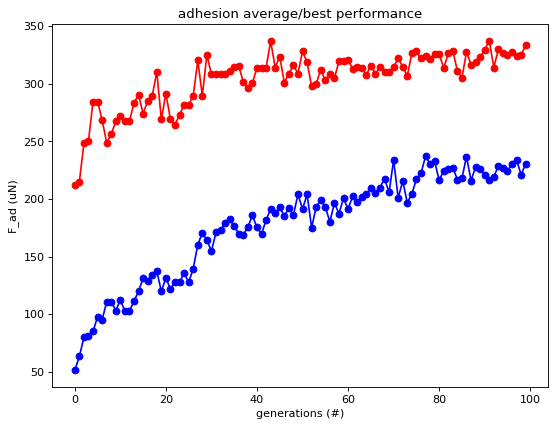

In [12]:
# test block for GA 10
N_GENERATIONS = 100         # number of generations
POP_SIZE = 100
DNA_SIZE = 40
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability

failed_lines = []

pop = np.random.uniform(-1,1, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

class Material:

    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:

    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

def translateDNA(pop): # DNA samples to split into different gene groups, e.g. An, Bn
    
    An = pop[:,:int(DNA_SIZE/2)]
    Bn = pop[:,int(DNA_SIZE/2):]
    return An, Bn

def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)
    return total

def F(lines): 
    F_ads = []
    
    for i, line in enumerate(lines.tolist()):
        geo = Geometry(curve = line)
        mat = Material()
        fb = Fiber(mat, geo)
        F_ad = fb.find_F_ad()
        if fb.failed_line != None:
            failed_lines.append(fb.failed_line) 
        print(f'F_ad_{i} = {F_ad:.2f}')
        F_ads.append(F_ad) 
#         mapdl.eplot(title='element Plot', line_width=1, show_bounds=True, cpos="xy")
    return np.array(F_ads)     

def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
#         print(cross_points)
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = random.uniform(-1,1)                        
    return child

# GA begins here:
pop = Coefficient_Gen(pop_size = POP_SIZE)   # initialize the pop DNA

gen_average=[]
gen_bestscore=[]
gen_best=[]

for i in range(N_GENERATIONS):
    An, Bn = translateDNA(pop)
    lines = to_Fourier(An, Bn)
    F_values = F(lines)

    
    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    gen_average.append(np.average(F_values))  
    gen_bestscore.append(np.max(F_values)) 
    gen_best.append(lines[np.argmax(fitness), :])
    
    print(f'gen{i}: avg={gen_average[i]:.1f}, max={gen_bestscore[i]:.1f}, best ={gen_best[i]}')  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child    
        
list_gens = range(0,N_GENERATIONS)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()


import csv

with open('sample_10.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed lines'])
    write.writerow(failed_lines)
    